# Floc Analysis

This page shows an example of doing an analysis of the watercolumn floc using the CamHDHub and Dask. The goal of this work is to understand changes in the concentration of "floc", or bacterial material that has been flushed from the hydrothermal system into the ocean. Changes in floc are an indicator of changes in the hydrothermal system, often as a result of a magmatic event or seismic swarm.

This notebook uses [Dask](http://dask.pydata.org/en/latest/) to analyze a large number of frames to establish a proxy for the floc concentration, then plots this value using a two-dimensional multivariate histogram.

This version of the floc analysis uses the new regions [metadata](https://github.com/CamHD-Analysis/CamHD_motion_metadata) in CSV format generated by Aaron Marburg.

#### Setup environment

In [1]:
%matplotlib inline
import pycamhd.pycamhd as camhd
import numpy as np
import matplotlib.pyplot as plt

#### Get a list of CamHD files to process and metadata

In [2]:
import csv
import requests
csv_url = 'https://raw.githubusercontent.com/CamHD-Analysis/CamHD_motion_metadata/master/datapackage/regions.csv'

with requests.Session() as s:
    download = s.get(csv_url)
    decoded_content = download.content.decode('utf-8')
    reader = csv.DictReader(decoded_content.splitlines())
    d2_p2_z0 = [r for r in reader if r['scene_tag'] == 'd2_p2_z0']

filenames = list(set([d['mov_basename'] for d in d2_p2_z0]))
filenames.sort()

#### Set up a function to return a frame number based on region metadata and a "relative" frame number
Here we build a list of every frame from a particular scene in a movie using the regions metadata, and assuming that n_frames will be requested, we break this list into groupings of n_frames, and return the first frame from one of these groups based on relative_frame_number. This method quasi-randomly samples the scene, allowing for multiple instances of a scene per movie.

In [3]:
def real_frame_number(filename, relative_frame_number, n_frames):
    scenes = [r for r in d2_p2_z0 if r['mov_basename'] == filename]
    frames = []
    for i in scenes:
        range(int(i['start_frame']), int(i['end_frame']))
        frames = frames + range(int(i['start_frame']), int(i['end_frame'])+1)   
    return frames[int(round(float(relative_frame_number)/(n_frames-1)*len(frames)))-1]

#### Create the filter for filtering images in the frequency domain
To deal with variations in lighting and high-frequency noise, we filter each subimage using a Butterworth bandpass filter.

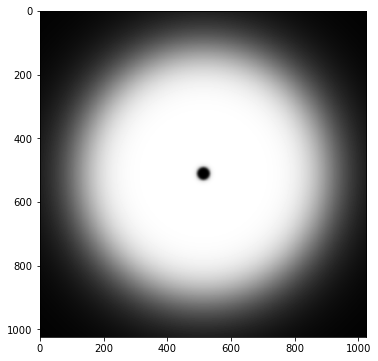

In [4]:
plt.rc('figure', figsize=(6, 6))
d1 = 20; # low cut wavenumber
d2 = 400; # high cut wavenumber
n = 4;
x = np.arange(-1024/2+0.5,1024/2+1-0.5)
xx, yy = np.meshgrid(x, x)
d = np.sqrt(xx**2+yy**2);
bff = (1 - (1./(1 + (d/d1)**(2*n))))*(1/(1 + (d/d2)**(2*n))); # Butterworth bandpass filter
imgplot = plt.imshow(bff, cmap='gray')

#### Setup the Dask delayed functions
The floc proxy is simply the number of pixels in each filtered subimage that have a value greater than 4000.

In [5]:
from dask.multiprocessing import get
from dask import delayed, compute

@delayed
def delayed_real_frame_number(filename, relative_frame_number, n_frames):
    return real_frame_number(filename, relative_frame_number, n_frames)

@delayed
def delayed_get_frame(filename, frame_number, pix_fmt):
    return camhd.get_frame(filename, frame_number, pix_fmt)

@delayed
def delayed_get_floc_proxy(frame):
    I = frame[0:1024, 0:1024]
    I_fft = np.fft.fft2(I);
    I_fft_shift = np.fft.fftshift(I_fft);
    I_fft_shift_filt = I_fft_shift*bff; # filter with the Butterworth filter
    I_fft_filt = np.fft.ifftshift(I_fft_shift_filt);
    I_filt = np.fft.ifft2(I_fft_filt);
    return (np.absolute(I_filt)>4000).sum()

#### Calculate the floc_proxy using Dask parallelization
We use Dask to handle load balancing among processors on the system.

In [6]:
%%time
delayed_floc_proxy = []
n_frames = 50 # number of frames to use in for each video
relative_frame_numbers = range(0,n_frames)
for filename in filenames:
    for relative_frame_number in relative_frame_numbers:
        frame_number = delayed_real_frame_number(filename, relative_frame_number, n_frames)
        frame = delayed_get_frame('/data/' + filename + '.mov', frame_number, 'gray16le')
        delayed_floc_proxy.append(delayed_get_floc_proxy(frame))
floc_proxy = compute(*delayed_floc_proxy)

CPU times: user 7h 54min 9s, sys: 12min 23s, total: 8h 6min 32s
Wall time: 1h 14min 9s


#### Get a timestamp for each frame

In [7]:
import datetime, math
import matplotlib.dates as dates
frame_timestamp = []
for filename in filenames:
    for relative_frame_number in relative_frame_numbers:
        frame_number = real_frame_number(filename, relative_frame_number, n_frames)
        year = int(filename[10:14])
        month = int(filename[14:16])
        day = int(filename[16:18])
        hour = int(filename[19:21])
        minute = int(math.floor(frame_number/29.95/60))
        second = int(math.floor(frame_number/29.95-minute*60))
        microsecond = int(round((frame_number/29.95-second-minute*60)*1000000))
        dt = datetime.datetime(year, month, day, hour, minute, second, microsecond)           
        frame_timestamp.append(dates.date2num(dt))

#### Plot a two-dimensional multivariate histogram of the results

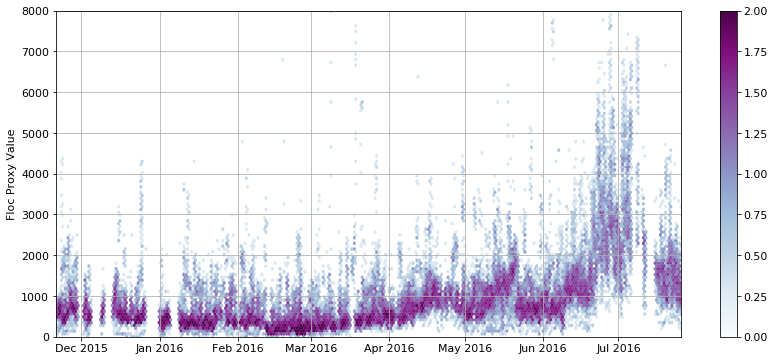

In [8]:
plt.rc('font', size=11)
fig, ax = plt.subplots();
fig.set_size_inches(14, 6);
fig.frameon = False
hb1 = ax.hexbin(frame_timestamp, floc_proxy, vmin=0, vmax=2, bins='log', linewidths=0.25,
  gridsize=(240,80), mincnt=1, cmap=plt.cm.BuPu)
fig.colorbar(hb1)
ax.set_ylim([0, 8000])
ax.set_xlim([frame_timestamp[0],frame_timestamp[-1]])
ax.yaxis.grid(True)
ax.xaxis.grid(True)
months = dates.MonthLocator()  # every month
monthsFmt = dates.DateFormatter('%b %Y')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
plt.ylabel('Floc Proxy Value');

# print
#fig_dpi = 300
#fig.savefig('floc_hexbin.png', bbox_inches='tight', transparent=True,
#  pad_inches=0, orientation='portrait', format='png', dpi=fig_dpi);

Starting in late-June a large "floc event" occurs where the floc proxy values increase on average by nearly a factor of ten. The cause of this floc event is being investigated.

### References

PyCamHD: https://github.com/tjcrone/pycamhd<br>
CamHDHub: https://github.com/tjcrone/camhdhub<br>
Raw Data Archive: https://rawdata.oceanobservatories.org/files/RS03ASHS/PN03B/06-CAMHDA301/<br>
AGU Abstract: https://agu.confex.com/agu/fm16/meetingapp.cgi/Paper/192670<br>
AGU Poster: https://drive.google.com/open?id=0B-dWW4GM434obGpTM0FZME10Nkk<br>
Dask: http://dask.pydata.org/en/latest/